##Problem Statement: Machine Learning for Fraudulent Transaction Classification in E-Commerce: A Case Study of the Pesapal Platform

####1. Introduction & Background

The exponential growth of e-commerce has been paralleled by a surge in sophisticated financial fraud, posing significant challenges to payment service providers like Pesapal. Fraudulent transactions lead to direct financial losses, erode customer trust, damage brand reputation, and incur substantial operational costs for fraud investigation and chargeback handling. While rule-based systems have been traditionally used for fraud detection, they often suffer from high false-positive rates, lack adaptability to evolving fraud patterns, and require constant manual updates.

Machine Learning (ML) offers a promising paradigm shift by enabling systems to learn complex, non-linear patterns from historical transaction data and adapt to new fraudulent tactics. The ability to accurately distinguish between legitimate and fraudulent transactions in real-time is critical for maintaining the integrity and security of digital payment ecosystems.

####2. Problem Definition

This research addresses the critical challenge of accurately classifying fraudulent transactions on Pesapal's e-commerce platform. The core problem is a binary classification task: given a set of transaction attributes (e.g., time, amount, merchant ID, customer location, device fingerprint), the objective is to assign a label of either "legitimate" or "fraudulent."

The primary complication is the highly imbalanced nature of the dataset, where fraudulent transactions represent a very small minority (often less than 1%) of all transactions. This class imbalance can bias standard classification algorithms towards predicting the majority class, leading to high overall accuracy but poor detection of the critical minority class (fraud). Therefore, the problem extends beyond simple classification to developing a robust model that effectively handles severe class imbalance.

####3. Research Gap & Justification

Although ML models for fraud detection have been widely studied, their performance is highly dependent on the specific context, data features, and fraud patterns unique to a platform. A model trained on data from one financial institution may not generalize well to another. There is a identified gap in the academic literature concerning the application and evaluation of advanced ML techniques specifically on transaction data from African fintech platforms like Pesapal, which may exhibit distinct transactional behaviors and fraud schemes compared to global counterparts.

####4. Research Objectives

The main objective of this study is to develop and evaluate a high-performance machine learning model for the accurate classification of fraudulent transactions on the Pesapal platform.

To achieve this, the following specific objectives are defined:

    To preprocess and engineer features from Pesapal's historical transaction dataset to make it suitable for machine learning modeling.

    To address the class imbalance problem.

    To train, validate, and compare the performance of multiple machine learning algorithms, including but not limited to: Logistic Regression, Decision Trees, Random Forests, Gradient Boosting Machines (e.g., XGBoost, LightGBM, CatBoost), and potentially neural networks.

    To optimize the hyperparameters of the most promising models to maximize detection performance.

    To evaluate the final model not just on overall accuracy, but on metrics appropriate for imbalanced datasets, such as Precision, Recall, F1-Score, Area Under the Precision-Recall Curve (AUPRC), and Area Under the Receiver Operating Characteristic Curve (AUC-ROC).

####5. Scope and Delimitations

This study will be confined to the historical transaction data provided by Pesapal. The research will focus on the classification task itself and will not extend to the real-time deployment and integration of the model into production systems. The feature set will be limited to the variables available within the provided dataset.





    


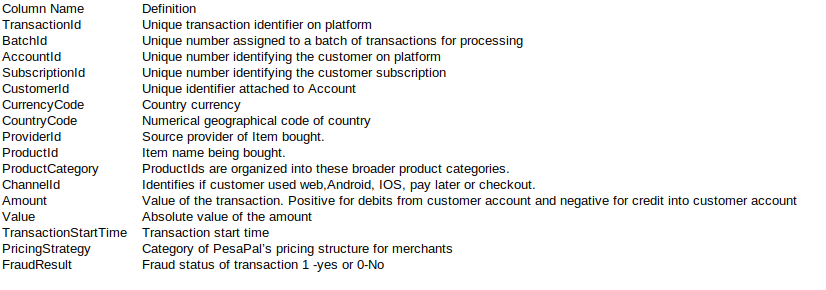

In [ ]:
# Import all required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# For interactive plots (install with: pip install plotly)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
PLOTLY_AVAILABLE = True
print("✅ Plotly available - Interactive plots enabled")


# Set style for better looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)



✅ Plotly available - Interactive plots enabled


In [ ]:
#load data
train = pd.read_csv('/content/drive/MyDrive/PesaPal/training.csv')
test = pd.read_csv('/content/drive/MyDrive/PesaPal/test.csv')

In [ ]:
# Check for missing values
print(" DATA QUALITY ASSESSMENT")
print("="*50)

print("Missing Values in Training Set:")
missing_train = train.isnull().sum()
print(missing_train[missing_train > 0])

print("\n Missing Values in Test Set:")
missing_test = test.isnull().sum()
print(missing_test[missing_test > 0])

# Data types overview
print(f"\n Data Types Overview:")
print(train.dtypes.value_counts())

# Unique values for categorical columns
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
print(f"\n Categorical Columns: {len(categorical_cols)}")
for col in categorical_cols:
    unique_count = train[col].nunique()
    print(f"  {col}: {unique_count} unique values")

# Numerical columns summary
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n Numerical Columns: {len(numerical_cols)}")
for col in numerical_cols:
    if col != 'FraudResult':
        print(f"  {col}: min={train[col].min():.2f}, max={train[col].max():.2f}")

 DATA QUALITY ASSESSMENT
Missing Values in Training Set:
Series([], dtype: int64)

 Missing Values in Test Set:
Series([], dtype: int64)

 Data Types Overview:
object     11
int64       4
float64     1
Name: count, dtype: int64

 Categorical Columns: 11
  TransactionId: 95662 unique values
  BatchId: 94809 unique values
  AccountId: 3633 unique values
  SubscriptionId: 3627 unique values
  CustomerId: 3742 unique values
  CurrencyCode: 1 unique values
  ProviderId: 6 unique values
  ProductId: 23 unique values
  ProductCategory: 9 unique values
  ChannelId: 4 unique values
  TransactionStartTime: 94556 unique values

 Numerical Columns: 5
  CountryCode: min=256.00, max=256.00
  Amount: min=-1000000.00, max=9880000.00
  Value: min=2.00, max=9880000.00
  PricingStrategy: min=0.00, max=4.00


 FRAUD DISTRIBUTION ANALYSIS


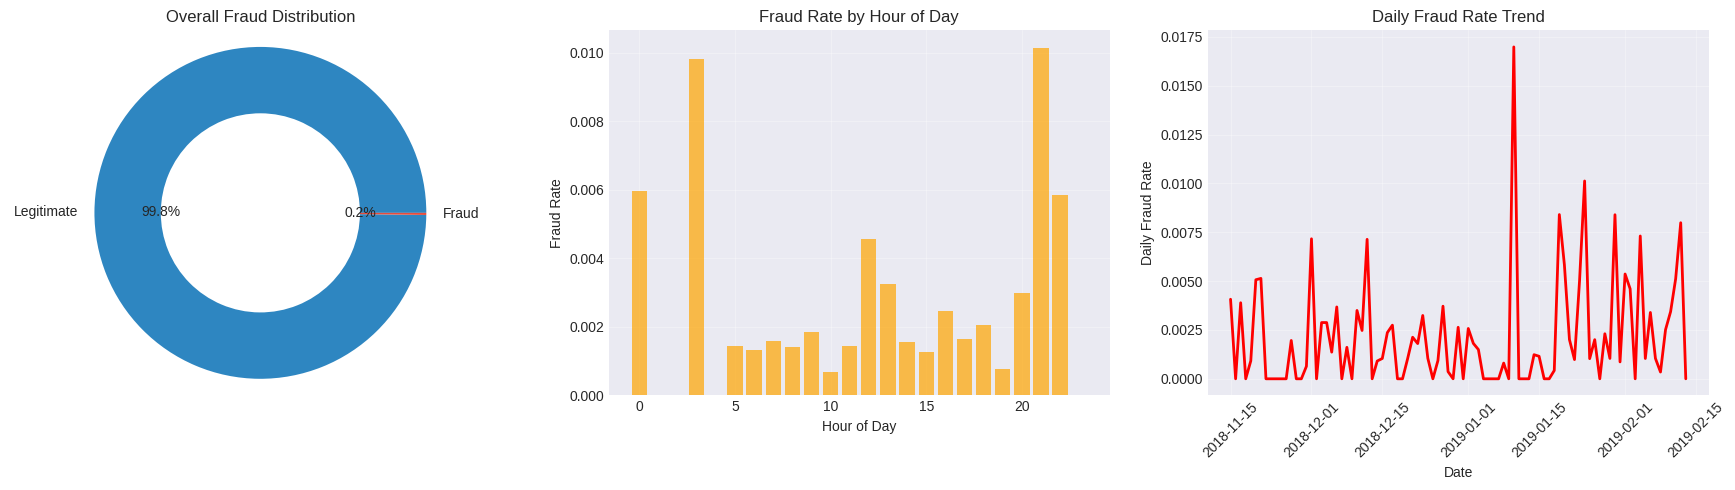


 Key Fraud Statistics:
Peak fraud hour: 21:00 (1.0%)
Lowest fraud hour: 1:00 (0.0%)
Average daily fraud rate: 0.2%
Highest daily fraud rate: 1.7%


In [ ]:
# Fraud distribution analysis
print(" FRAUD DISTRIBUTION ANALYSIS")
print("="*50)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Simple count plot with inner circle
fraud_counts = train['FraudResult'].value_counts()

# Create the pie chart
axes[0].pie(
    fraud_counts.values,
    labels=['Legitimate', 'Fraud'],
    autopct='%1.1f%%',
    colors=['#2E86C1', '#E74C3C'],
    wedgeprops={'width': 0.4}  # Makes room for the inner circle
)

# Optional: Add a white circle in the middle (perfect for donut style)
centre_circle = plt.Circle((0, 0), 0.02, fc='white')
axes[0].add_artist(centre_circle)

axes[0].set_title('Overall Fraud Distribution')
axes[0].axis('equal')  # Keep it a circle

# Convert 'TransactionStartTime' to datetime
train['TransactionStartTime'] = pd.to_datetime(train['TransactionStartTime'])

# 2. Fraud rate by hour
train['Hour'] = train['TransactionStartTime'].dt.hour
hourly_fraud = train.groupby('Hour')['FraudResult'].agg(['sum', 'count'])
hourly_fraud['rate'] = hourly_fraud['sum'] / hourly_fraud['count']

axes[1].bar(hourly_fraud.index, hourly_fraud['rate'], color='orange', alpha=0.7)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Fraud Rate')
axes[1].set_title('Fraud Rate by Hour of Day')
axes[1].grid(True, alpha=0.3)

# 3. Daily fraud trend
daily_fraud = train.set_index('TransactionStartTime')['FraudResult'].resample('D').agg(['sum', 'count'])
daily_fraud['rate'] = daily_fraud['sum'] / daily_fraud['count']

axes[2].plot(daily_fraud.index, daily_fraud['rate'], color='red', linewidth=2)
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Daily Fraud Rate')
axes[2].set_title('Daily Fraud Rate Trend')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key statistics
print(f"\n Key Fraud Statistics:")
print(f"Peak fraud hour: {hourly_fraud['rate'].idxmax()}:00 ({hourly_fraud['rate'].max():.1%})")
print(f"Lowest fraud hour: {hourly_fraud['rate'].idxmin()}:00 ({hourly_fraud['rate'].min():.1%})")
print(f"Average daily fraud rate: {daily_fraud['rate'].mean():.1%}")
print(f"Highest daily fraud rate: {daily_fraud['rate'].max():.1%}")

 AMOUNT & VALUE ANALYSIS


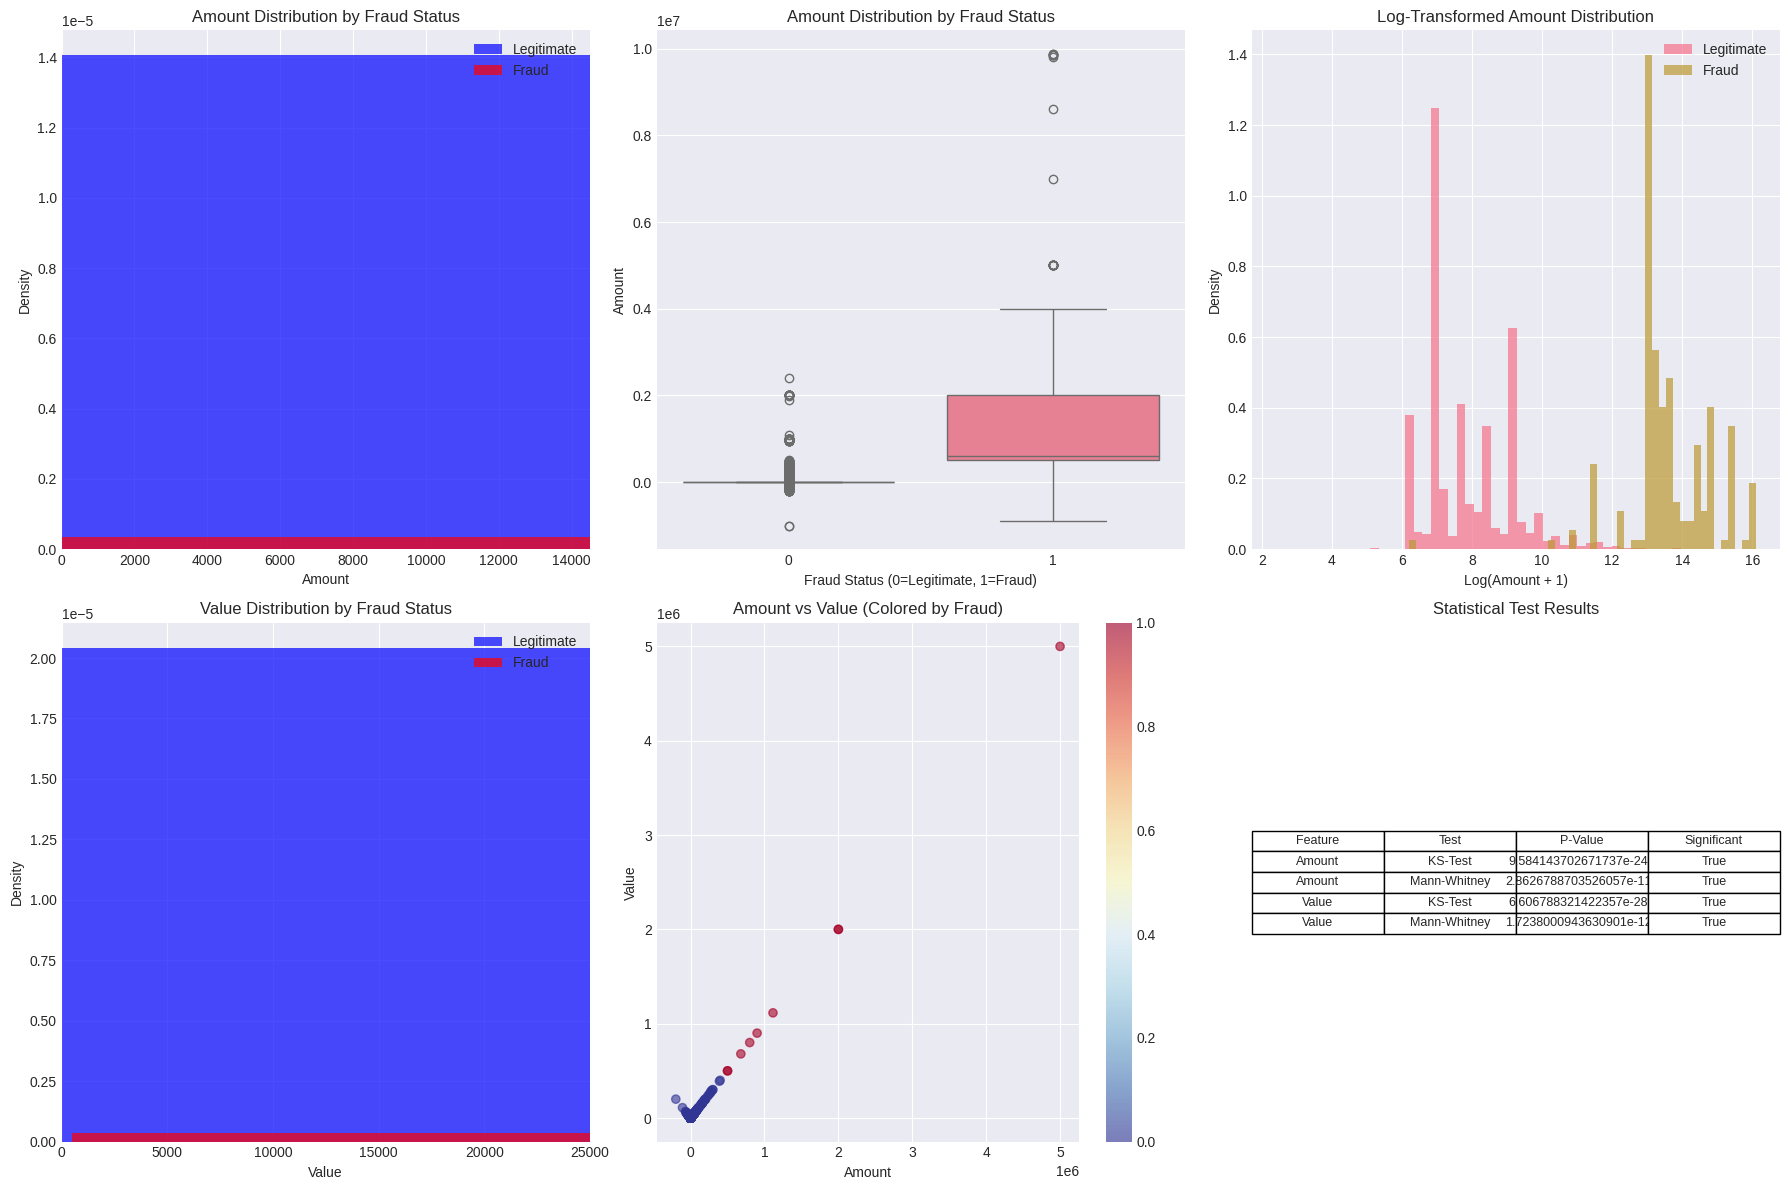


 Amount Statistics:
Legitimate: Mean=3627.72, Median=1000.00
Fraud: Mean=1535272.39, Median=600000.00

 Value Statistics:
Legitimate: Mean=6763.23, Median=1000.00
Fraud: Mean=1561819.54, Median=650000.00


In [ ]:
# Analyze Amount and Value distributions
print(" AMOUNT & VALUE ANALYSIS")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Amount analysis
legitimate_amounts = train[train['FraudResult'] == 0]['Amount']
fraud_amounts = train[train['FraudResult'] == 1]['Amount']

# 1. Amount distribution
axes[0,0].hist(legitimate_amounts, bins=50, alpha=0.7, label='Legitimate', density=True, color='blue')
axes[0,0].hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', density=True, color='red')
axes[0,0].set_xlabel('Amount')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Amount Distribution by Fraud Status')
axes[0,0].legend()
axes[0,0].set_xlim(0, train['Amount'].quantile(0.95))  # Remove extreme outliers for visibility

# 2. Amount box plot
train_melted = pd.melt(train[['FraudResult', 'Amount']],
                      id_vars=['FraudResult'], value_vars=['Amount'])
sns.boxplot(data=train, x='FraudResult', y='Amount', ax=axes[0,1])
axes[0,1].set_title('Amount Distribution by Fraud Status')
axes[0,1].set_xlabel('Fraud Status (0=Legitimate, 1=Fraud)')

# 3. Log-transformed Amount
axes[0,2].hist(np.log1p(legitimate_amounts), bins=50, alpha=0.7, label='Legitimate', density=True)
axes[0,2].hist(np.log1p(fraud_amounts), bins=50, alpha=0.7, label='Fraud', density=True)
axes[0,2].set_xlabel('Log(Amount + 1)')
axes[0,2].set_ylabel('Density')
axes[0,2].set_title('Log-Transformed Amount Distribution')
axes[0,2].legend()

# Value analysis
legitimate_values = train[train['FraudResult'] == 0]['Value']
fraud_values = train[train['FraudResult'] == 1]['Value']

# 4. Value distribution
axes[1,0].hist(legitimate_values, bins=50, alpha=0.7, label='Legitimate', density=True, color='blue')
axes[1,0].hist(fraud_values, bins=50, alpha=0.7, label='Fraud', density=True, color='red')
axes[1,0].set_xlabel('Value')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Value Distribution by Fraud Status')
axes[1,0].legend()
axes[1,0].set_xlim(0, train['Value'].quantile(0.95))

# 5. Amount vs Value scatter plot
sample_size = min(5000, len(train))  # Sample for performance
sample_data = train.sample(sample_size)
scatter = axes[1,1].scatter(sample_data['Amount'], sample_data['Value'],
                           c=sample_data['FraudResult'], cmap='RdYlBu_r', alpha=0.6)
axes[1,1].set_xlabel('Amount')
axes[1,1].set_ylabel('Value')
axes[1,1].set_title('Amount vs Value (Colored by Fraud)')
plt.colorbar(scatter, ax=axes[1,1])

# 6. Statistical comparison
# Perform statistical tests
from scipy.stats import ks_2samp, mannwhitneyu

ks_stat_amount, ks_p_amount = ks_2samp(legitimate_amounts, fraud_amounts)
mw_stat_amount, mw_p_amount = mannwhitneyu(legitimate_amounts, fraud_amounts)

ks_stat_value, ks_p_value = ks_2samp(legitimate_values, fraud_values)
mw_stat_value, mw_p_value = mannwhitneyu(legitimate_values, fraud_values)

# Create a summary table
test_results = pd.DataFrame({
    'Feature': ['Amount', 'Amount', 'Value', 'Value'],
    'Test': ['KS-Test', 'Mann-Whitney', 'KS-Test', 'Mann-Whitney'],
    'P-Value': [ks_p_amount, mw_p_amount, ks_p_value, mw_p_value],
    'Significant': [ks_p_amount < 0.05, mw_p_amount < 0.05, ks_p_value < 0.05, mw_p_value < 0.05]
})

axes[1,2].axis('tight')
axes[1,2].axis('off')
table = axes[1,2].table(cellText=test_results.values, colLabels=test_results.columns,
                        cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
axes[1,2].set_title('Statistical Test Results')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n Amount Statistics:")
print(f"Legitimate: Mean={legitimate_amounts.mean():.2f}, Median={legitimate_amounts.median():.2f}")
print(f"Fraud: Mean={fraud_amounts.mean():.2f}, Median={fraud_amounts.median():.2f}")

print(f"\n Value Statistics:")
print(f"Legitimate: Mean={legitimate_values.mean():.2f}, Median={legitimate_values.median():.2f}")
print(f"Fraud: Mean={fraud_values.mean():.2f}, Median={fraud_values.median():.2f}")

 CORRELATION & FEATURE IMPORTANCE ANALYSIS
✅ Mutual Information calculated for 5 features


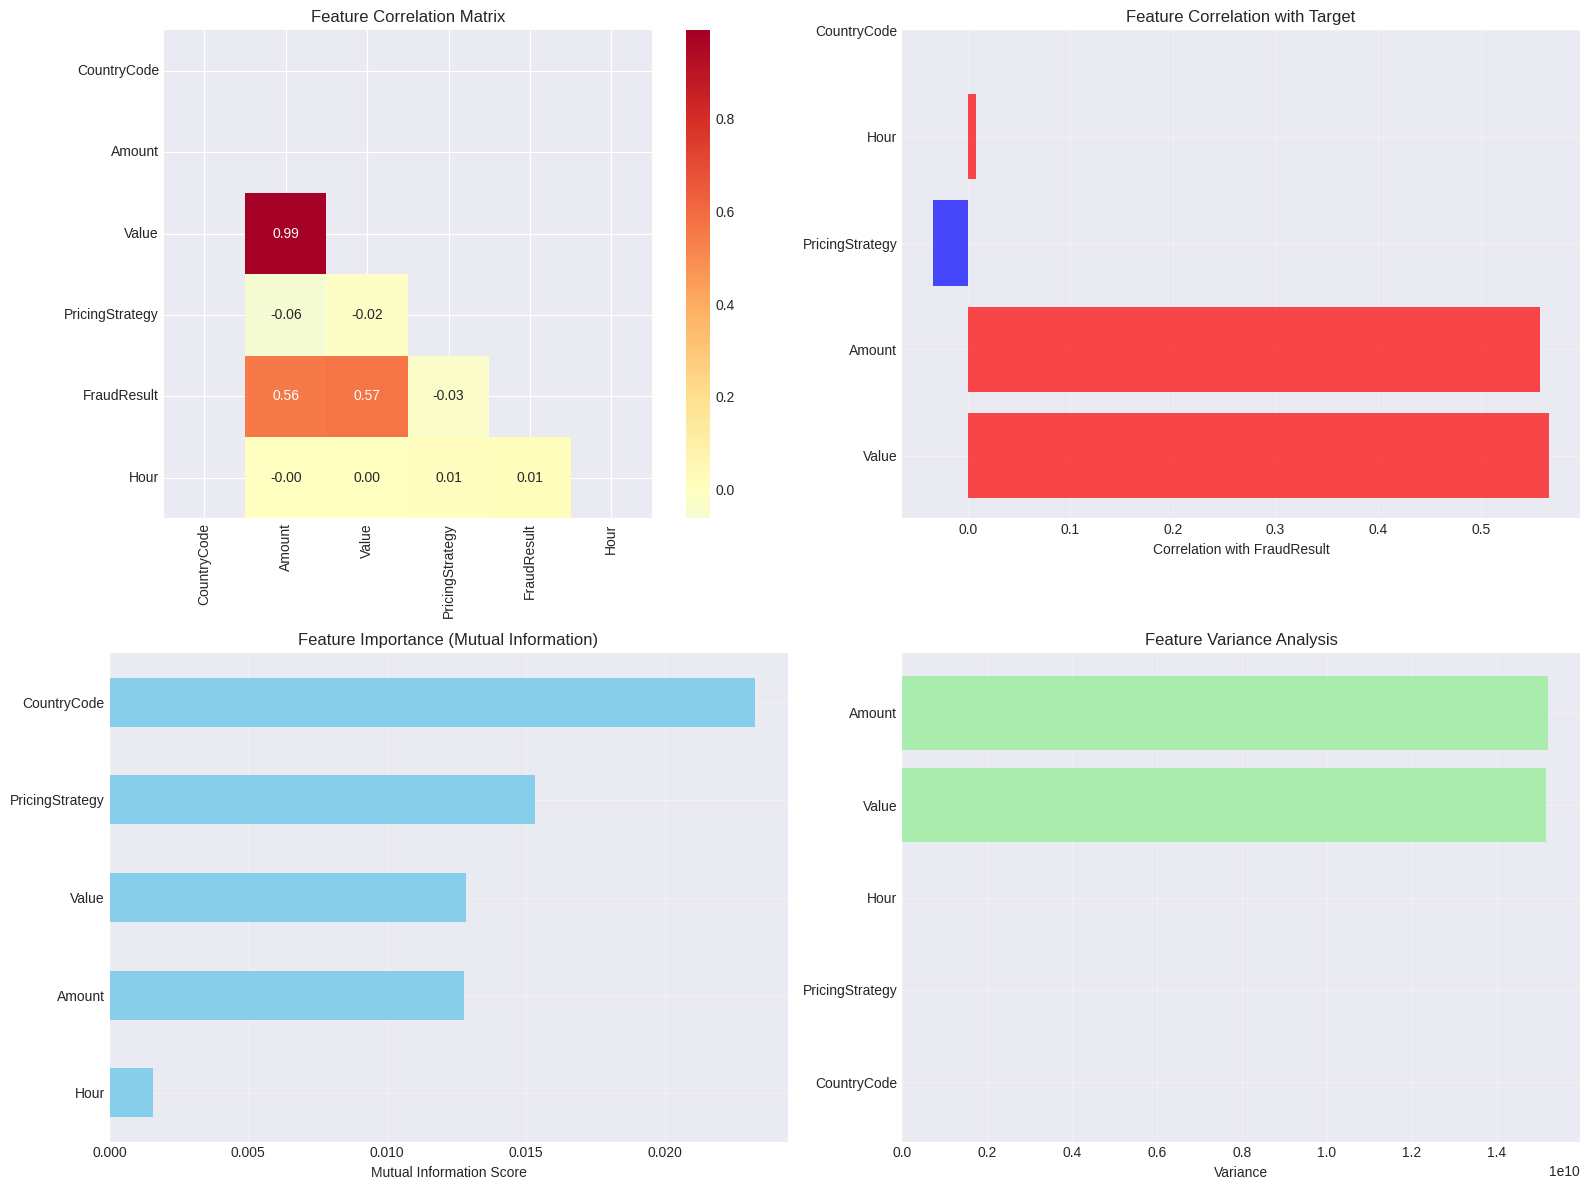


🔝 Top Feature Correlations with Fraud:
  Value: 0.567
  Amount: 0.557
  PricingStrategy: -0.034
  Hour: 0.008
  CountryCode: nan


In [ ]:
# Correlation analysis and feature importance
print(" CORRELATION & FEATURE IMPORTANCE ANALYSIS")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Correlation heatmap
numeric_cols = train.select_dtypes(include=[np.number]).columns
correlation_matrix = train[numeric_cols].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
            center=0, ax=axes[0,0], fmt='.2f', square=True)
axes[0,0].set_title('Feature Correlation Matrix')

# 2. Correlation with target variable
target_corr = correlation_matrix['FraudResult'].drop('FraudResult').sort_values(key=abs, ascending=False)
colors = ['red' if x > 0 else 'blue' for x in target_corr.values]
axes[0,1].barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.7)
axes[0,1].set_yticks(range(len(target_corr)))
axes[0,1].set_yticklabels(target_corr.index)
axes[0,1].set_xlabel('Correlation with FraudResult')
axes[0,1].set_title('Feature Correlation with Target')
axes[0,1].grid(True, alpha=0.3)

# 3. Feature importance using mutual information
try:
    from sklearn.feature_selection import mutual_info_classif

    # Prepare features (remove target and handle missing values)
    feature_cols = [col for col in numeric_cols if col != 'FraudResult']
    X_features = train[feature_cols].fillna(0)
    y_target = train['FraudResult']

    # Calculate mutual information scores
    mi_scores = mutual_info_classif(X_features, y_target, random_state=42)
    mi_scores_series = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=True)

    # Plot mutual information scores
    mi_scores_series.plot(kind='barh', ax=axes[1,0], color='skyblue')
    axes[1,0].set_title('Feature Importance (Mutual Information)')
    axes[1,0].set_xlabel('Mutual Information Score')
    axes[1,0].grid(True, alpha=0.3)

    print(f"✅ Mutual Information calculated for {len(feature_cols)} features")

except ImportError:
    axes[1,0].text(0.5, 0.5, 'Scikit-learn not available\nfor Mutual Information',
                   ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Feature Importance (Mutual Information)')

# 4. Feature variance analysis
feature_variances = train[feature_cols].var().sort_values(ascending=True)
axes[1,1].barh(range(len(feature_variances)), feature_variances.values, color='lightgreen', alpha=0.7)
axes[1,1].set_yticks(range(len(feature_variances)))
axes[1,1].set_yticklabels(feature_variances.index)
axes[1,1].set_xlabel('Variance')
axes[1,1].set_title('Feature Variance Analysis')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print top correlations
print(f"\n🔝 Top Feature Correlations with Fraud:")
for feature, corr in target_corr.head(5).items():
    print(f"  {feature}: {corr:.3f}")


 TIME SERIES DEEP DIVE ANALYSIS


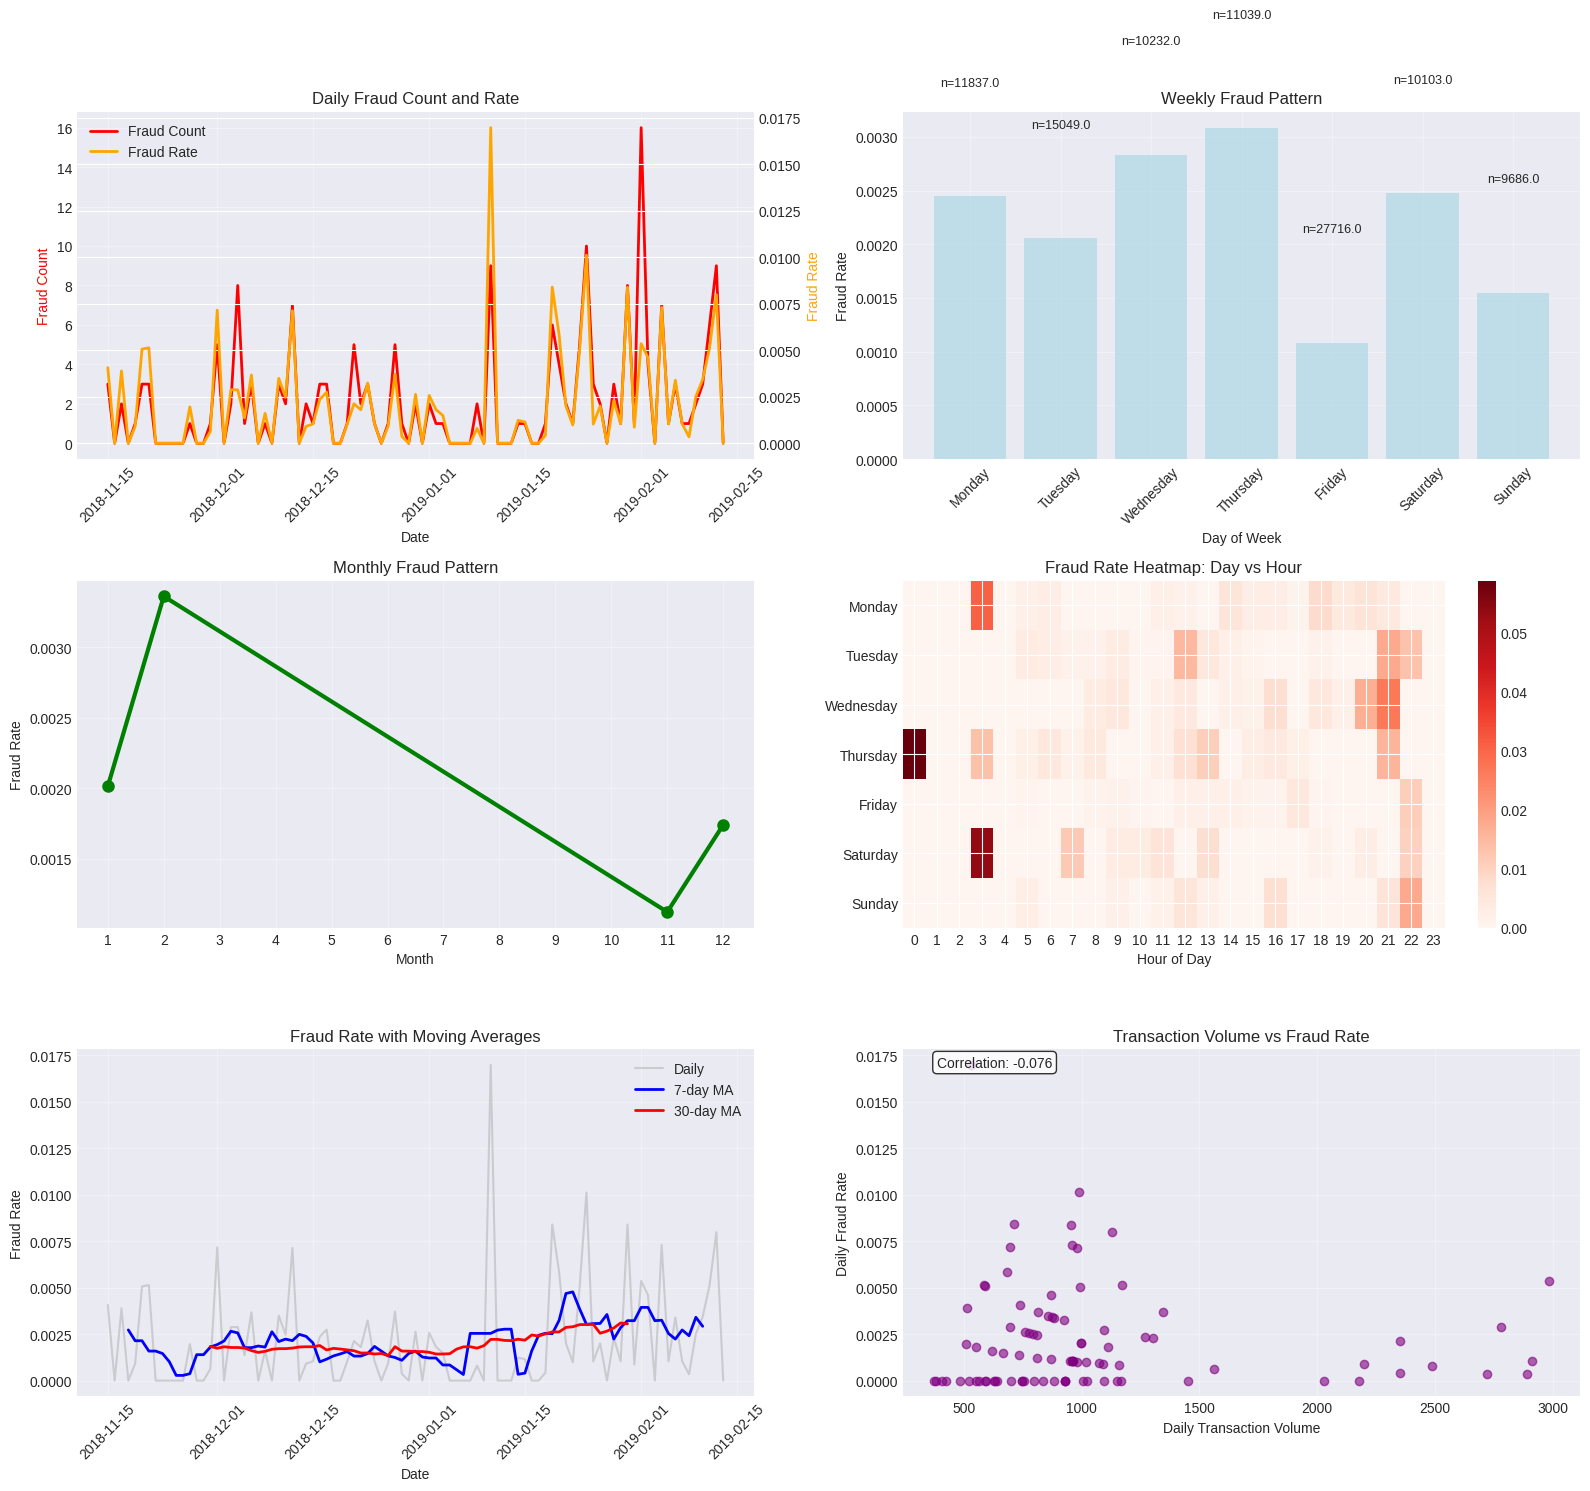


 Time-based Insights:
Highest risk day: Thursday (0.3%)
Lowest risk day: Friday (0.1%)
Highest risk month: 2 (0.3%)
Peak fraud hour: 21:00
Volume-Fraud correlation: -0.076


In [ ]:
# Advanced time series analysis
print(" TIME SERIES DEEP DIVE ANALYSIS")
print("="*50)

# Prepare time-based features
train['Date'] = train['TransactionStartTime'].dt.date
train['Hour'] = train['TransactionStartTime'].dt.hour
train['DayOfWeek'] = train['TransactionStartTime'].dt.day_name()
train['Month'] = train['TransactionStartTime'].dt.month
train['DayOfMonth'] = train['TransactionStartTime'].dt.day

fig, axes = plt.subplots(3, 2, figsize=(16, 15))

# 1. Daily fraud count and rate
daily_stats = train.groupby('Date')['FraudResult'].agg(['sum', 'count', 'mean'])
ax1 = axes[0,0]
ax2 = ax1.twinx()

line1 = ax1.plot(daily_stats.index, daily_stats['sum'], color='red', linewidth=2, label='Fraud Count')
line2 = ax2.plot(daily_stats.index, daily_stats['mean'], color='orange', linewidth=2, label='Fraud Rate')

ax1.set_xlabel('Date')
ax1.set_ylabel('Fraud Count', color='red')
ax2.set_ylabel('Fraud Rate', color='orange')
ax1.set_title('Daily Fraud Count and Rate')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 2. Weekly pattern
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_stats = train.groupby('DayOfWeek')['FraudResult'].agg(['sum', 'count', 'mean'])
weekly_stats = weekly_stats.reindex(day_order)

axes[0,1].bar(weekly_stats.index, weekly_stats['mean'], color='lightblue', alpha=0.7)
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Fraud Rate')
axes[0,1].set_title('Weekly Fraud Pattern')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Add count labels
for i, (day, row) in enumerate(weekly_stats.iterrows()):
    axes[0,1].text(i, row['mean'] + 0.001, f"n={row['count']}",
                   ha='center', va='bottom', fontsize=9)

# 3. Monthly pattern
monthly_stats = train.groupby('Month')['FraudResult'].agg(['sum', 'count', 'mean'])
axes[1,0].plot(monthly_stats.index, monthly_stats['mean'], marker='o', linewidth=3, markersize=8, color='green')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Fraud Rate')
axes[1,0].set_title('Monthly Fraud Pattern')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xticks(range(1, 13))

# 4. Hourly heatmap by day of week
hourly_daily = train.groupby(['DayOfWeek', 'Hour'])['FraudResult'].mean().unstack(fill_value=0)
hourly_daily = hourly_daily.reindex(day_order)

im = axes[1,1].imshow(hourly_daily.values, cmap='Reds', aspect='auto')
axes[1,1].set_xticks(range(24))
axes[1,1].set_yticks(range(7))
axes[1,1].set_yticklabels(day_order)
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_title('Fraud Rate Heatmap: Day vs Hour')
plt.colorbar(im, ax=axes[1,1])

# 5. Rolling statistics
daily_fraud_rate = daily_stats['mean']
rolling_7d = daily_fraud_rate.rolling(window=7, center=True).mean()
rolling_30d = daily_fraud_rate.rolling(window=30, center=True).mean()

axes[2,0].plot(daily_stats.index, daily_fraud_rate, alpha=0.3, color='gray', label='Daily')
axes[2,0].plot(daily_stats.index, rolling_7d, color='blue', linewidth=2, label='7-day MA')
axes[2,0].plot(daily_stats.index, rolling_30d, color='red', linewidth=2, label='30-day MA')
axes[2,0].set_xlabel('Date')
axes[2,0].set_ylabel('Fraud Rate')
axes[2,0].set_title('Fraud Rate with Moving Averages')
axes[2,0].legend()
axes[2,0].tick_params(axis='x', rotation=45)
axes[2,0].grid(True, alpha=0.3)

# 6. Transaction volume vs fraud rate correlation
axes[2,1].scatter(daily_stats['count'], daily_stats['mean'], alpha=0.6, color='purple')
axes[2,1].set_xlabel('Daily Transaction Volume')
axes[2,1].set_ylabel('Daily Fraud Rate')
axes[2,1].set_title('Transaction Volume vs Fraud Rate')
axes[2,1].grid(True, alpha=0.3)

# Add correlation coefficient
volume_fraud_corr = daily_stats['count'].corr(daily_stats['mean'])
axes[2,1].text(0.05, 0.95, f'Correlation: {volume_fraud_corr:.3f}',
               transform=axes[2,1].transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print time-based insights
print(f"\n Time-based Insights:")
print(f"Highest risk day: {weekly_stats['mean'].idxmax()} ({weekly_stats['mean'].max():.1%})")
print(f"Lowest risk day: {weekly_stats['mean'].idxmin()} ({weekly_stats['mean'].min():.1%})")
print(f"Highest risk month: {monthly_stats['mean'].idxmax()} ({monthly_stats['mean'].max():.1%})")
print(f"Peak fraud hour: {train.groupby('Hour')['FraudResult'].mean().idxmax()}:00")
print(f"Volume-Fraud correlation: {volume_fraud_corr:.3f}")

 ADVANCED FEATURE ENGINEERING
Creating new features...
✅ Feature engineering complete!


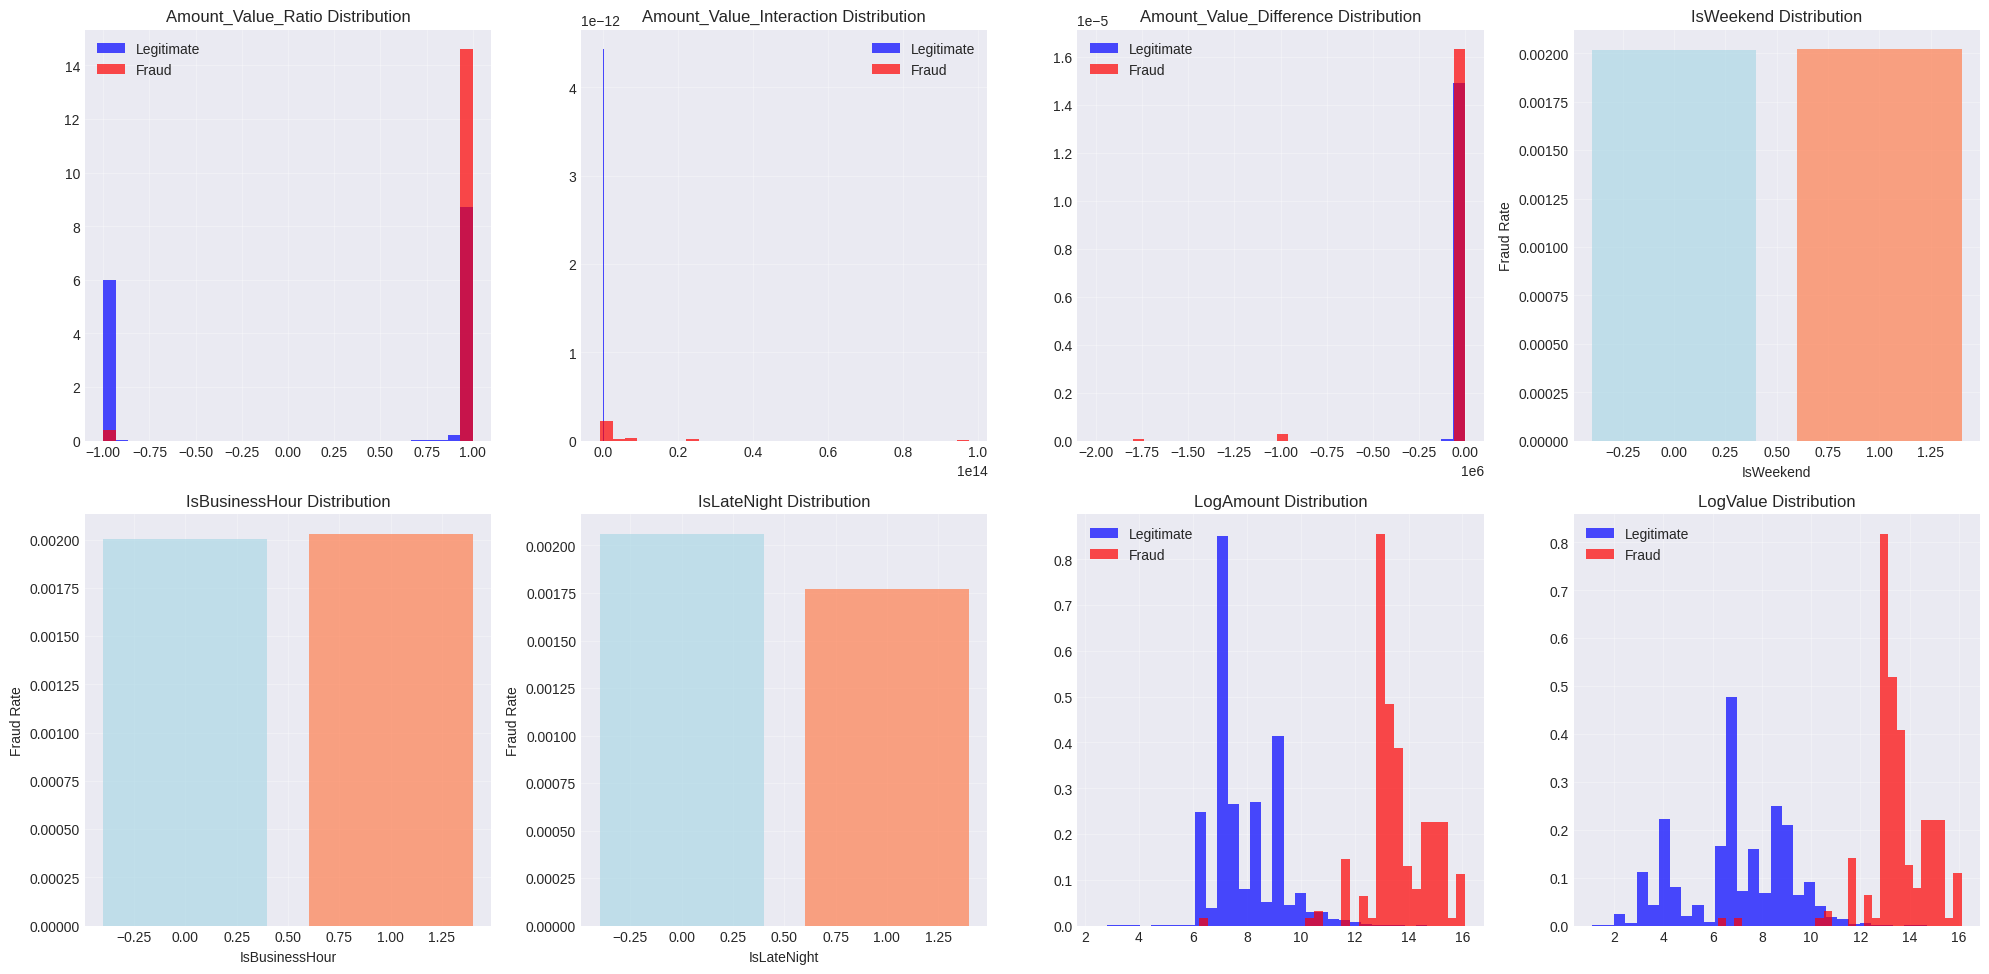


 New Feature Correlations with Fraud:
  Amount_Value_Ratio: 0.034
  Amount_Value_Interaction: 0.342
  Amount_Value_Difference: -0.059
  IsWeekend: 0.000
  IsBusinessHour: 0.000
  IsLateNight: -0.002
  LogAmount: 0.250
  LogValue: 0.139
  Account_TxnCount: -0.031
  Account_AvgAmount: 0.355
  Account_StdAmount: 0.380

Feature Engineering Summary:
Original features: 6
New features created: 11
Total features: 24


In [ ]:
# Advanced feature engineering
print(" ADVANCED FEATURE ENGINEERING")
print("="*50)

# Create new features
print("Creating new features...")

# 1. Amount and Value interactions
train['Amount_Value_Ratio'] = train['Amount'] / (train['Value'] + 1e-6)  # Add small value to avoid division by zero
train['Amount_Value_Interaction'] = train['Amount'] * train['Value']
train['Amount_Value_Difference'] = train['Amount'] - train['Value']

# 2. Time-based features
train['IsWeekend'] = train['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)
train['IsBusinessHour'] = ((train['Hour'] >= 9) & (train['Hour'] <= 17)).astype(int)
train['IsLateNight'] = ((train['Hour'] >= 22) | (train['Hour'] <= 6)).astype(int)

# 3. Statistical features (if we have multiple transactions per account)
if 'AccountId' in train.columns:
    account_stats = train.groupby('AccountId')['Amount'].agg(['count', 'mean', 'std', 'min', 'max'])
    account_stats.columns = ['Account_TxnCount', 'Account_AvgAmount', 'Account_StdAmount', 'Account_MinAmount', 'Account_MaxAmount']
    account_stats['Account_AmountRange'] = account_stats['Account_MaxAmount'] - account_stats['Account_MinAmount']

    # Merge back to main dataset
    train = train.merge(account_stats, left_on='AccountId', right_index=True, how='left')

# 4. Binning features
train['AmountBin'] = pd.qcut(train['Amount'], q=10, labels=False, duplicates='drop')
train['ValueBin'] = pd.qcut(train['Value'], q=10, labels=False, duplicates='drop')

# 5. Log transformations
train['LogAmount'] = np.log1p(train['Amount'])
train['LogValue'] = np.log1p(train['Value'])

print("✅ Feature engineering complete!")

# Analyze new features
new_features = ['Amount_Value_Ratio', 'Amount_Value_Interaction', 'Amount_Value_Difference',
                'IsWeekend', 'IsBusinessHour', 'IsLateNight', 'LogAmount', 'LogValue']

# Add account features if they exist
if 'Account_TxnCount' in train.columns:
    new_features.extend(['Account_TxnCount', 'Account_AvgAmount', 'Account_StdAmount'])

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, feature in enumerate(new_features[:8]):  # Plot first 8 features
    if feature in train.columns:
        # Check if feature is binary
        if train[feature].nunique() <= 2:
            # Bar plot for binary features
            fraud_rate = train.groupby(feature)['FraudResult'].mean()
            axes[idx].bar(fraud_rate.index, fraud_rate.values, color=['lightblue', 'coral'], alpha=0.7)
            axes[idx].set_xlabel(feature)
            axes[idx].set_ylabel('Fraud Rate')
        else:
            # Histogram for continuous features
            legitimate = train[train['FraudResult'] == 0][feature].dropna()
            fraud = train[train['FraudResult'] == 1][feature].dropna()

            if len(legitimate) > 0 and len(fraud) > 0:
                axes[idx].hist(legitimate, bins=30, alpha=0.7, label='Legitimate', density=True, color='blue')
                axes[idx].hist(fraud, bins=30, alpha=0.7, label='Fraud', density=True, color='red')
                axes[idx].legend()

        axes[idx].set_title(f'{feature} Distribution')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation of new features with target
print(f"\n New Feature Correlations with Fraud:")
for feature in new_features:
    if feature in train.columns:
        corr = train[feature].corr(train['FraudResult'])
        if not np.isnan(corr):
            print(f"  {feature}: {corr:.3f}")

# Feature summary
print(f"\nFeature Engineering Summary:")
print(f"Original features: {len(numeric_cols)}")
print(f"New features created: {len([f for f in new_features if f in train.columns])}")
print(f"Total features: {len(train.select_dtypes(include=[np.number]).columns)}")

In [ ]:
new_train = train.to_csv('new_train.csv', index=False)

In [ ]:
# Interactive dashboard with Plotly
if PLOTLY_AVAILABLE:
    print(" CREATING INTERACTIVE DASHBOARD")
    print("="*50)

    # Create interactive fraud overview dashboard
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=('Fraud Distribution', 'Daily Fraud Trends', 'Hourly Pattern',
                       'Amount by Fraud Status', 'Feature Correlation', 'Risk Analysis'),
        specs=[[{"type": "pie"}, {"type": "xy"}, {"type": "xy"}],
               [{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]]
    )

    # 1. Fraud distribution pie chart
    fraud_counts = train['FraudResult'].value_counts()
    fig.add_trace(go.Pie(
        labels=['Legitimate', 'Fraud'],
        values=[fraud_counts[0], fraud_counts[1]],
        hole=0.4,
        marker_colors=['#2E86C1', '#E74C3C'],
        textinfo='label+percent',
        name="Fraud Distribution",
        insidetextorientation='auto' # Corrected parameter
    ), row=1, col=1)

    # 2. Daily fraud trends
    daily_fraud = train.groupby('Date')['FraudResult'].agg(['sum', 'count', 'mean'])
    fig.add_trace(go.Scatter(
        x=daily_fraud.index,
        y=daily_fraud['mean'],
        mode='lines+markers',
        name='Daily Fraud Rate',
        line=dict(color='#E74C3C', width=2),
        hovertemplate='Date: %{x}<br>Fraud Rate: %{y:.1%}<extra></extra>'
    ), row=1, col=2)

    # 3. Hourly pattern
    hourly_fraud = train.groupby('Hour')['FraudResult'].agg(['sum', 'count', 'mean'])
    fig.add_trace(go.Bar(
        x=hourly_fraud.index,
        y=hourly_fraud['mean'],
        marker_color='#F39C12',
        name='Hourly Fraud Rate',
        hovertemplate='Hour: %{x}<br>Fraud Rate: %{y:.1%}<br>Count: %{customdata}<extra></extra>',
        customdata=hourly_fraud['count']
    ), row=1, col=3)

    # 4. Amount distribution by fraud status
    fig.add_trace(go.Box(
        y=train[train['FraudResult']==0]['Amount'],
        name='Legitimate',
        marker_color='#2E86C1',
        boxpoints='outliers'
    ), row=2, col=1)

    fig.add_trace(go.Box(
        y=train[train['FraudResult']==1]['Amount'],
        name='Fraud',
        marker_color='#E74C3C',
        boxpoints='outliers'
    ), row=2, col=1)

    # 5. Top feature correlations
    target_corr = train.select_dtypes(include=[np.number]).corr()['FraudResult'].drop('FraudResult')
    top_corr = target_corr.abs().nlargest(8)

    fig.add_trace(go.Bar(
        x=top_corr.values,
        y=top_corr.index,
        orientation='h',
        marker_color=['red' if x > 0 else 'blue' for x in target_corr[top_corr.index]],
        name='Feature Correlation'
    ), row=2, col=2)

    # 6. Risk analysis by amount bins
    amount_bins = pd.qcut(train['Amount'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    risk_by_bin = train.groupby(amount_bins)['FraudResult'].agg(['sum', 'count', 'mean'])

    fig.add_trace(go.Bar(
        x=risk_by_bin.index,
        y=risk_by_bin['mean'],
        marker_color='#8E44AD',
        name='Risk by Amount Tier',
        hovertemplate='Tier: %{x}<br>Fraud Rate: %{y:.1%}<br>Count: %{customdata}<extra></extra>',
        customdata=risk_by_bin['count']
    ), row=2, col=3)

    # Update layout
    fig.update_layout(
        title_text=" Interactive Fraud Detection Dashboard",
        title_x=0.5,
        height=800,
        showlegend=True,
        template='plotly_white'
    )

    # Show the interactive plot
    fig.show()

    print("Interactive dashboard created!")
    print(" Hover over elements for detailed information")
    print(" Click legend items to toggle visibility")

else:
    print(" Plotly not available - Skipping interactive dashboard")
    print("Install with: pip install plotly")

 CREATING INTERACTIVE DASHBOARD


Interactive dashboard created!
 Hover over elements for detailed information
 Click legend items to toggle visibility


 SUPERVISED FRAUD DETECTION PIPELINE

 Training LightGBM...
[LightGBM] [Info] Number of positive: 154, number of negative: 76375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2845
[LightGBM] [Info] Number of data points in the train set: 76529, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

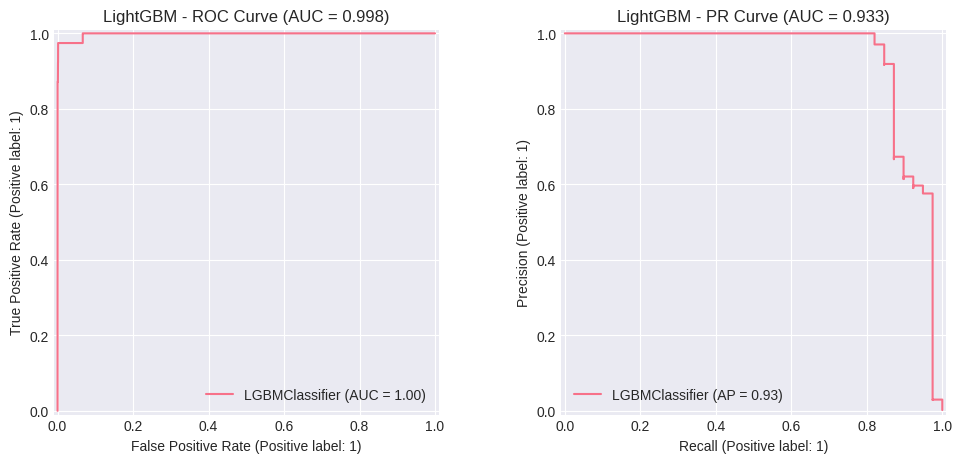


 LightGBM Results:
              precision    recall  f1-score   support

           0      1.000     0.999     0.999     19094
           1      0.680     0.872     0.764        39

    accuracy                          0.999     19133
   macro avg      0.840     0.935     0.882     19133
weighted avg      0.999     0.999     0.999     19133

Confusion Matrix:
 [[19078    16]
 [    5    34]]

 Training XGBoost...


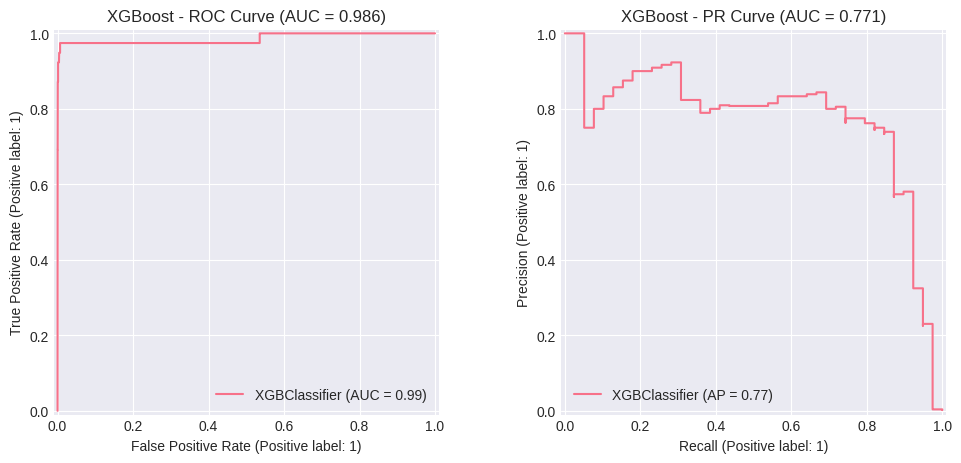


 XGBoost Results:
              precision    recall  f1-score   support

           0      1.000     0.999     0.999     19094
           1      0.567     0.872     0.687        39

    accuracy                          0.998     19133
   macro avg      0.783     0.935     0.843     19133
weighted avg      0.999     0.998     0.999     19133

Confusion Matrix:
 [[19068    26]
 [    5    34]]

 MODEL COMPARISON
LightGBM: ROC-AUC=0.998, PR-AUC=0.933
XGBoost: ROC-AUC=0.986, PR-AUC=0.771


In [ ]:
#  Supervised Fraud Detection Pipeline
print(" SUPERVISED FRAUD DETECTION PIPELINE")
print("="*60)

try:

    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        classification_report,
        confusion_matrix,
        roc_auc_score,
        precision_recall_curve,
        auc,
        RocCurveDisplay,
        PrecisionRecallDisplay
    )
    from lightgbm import LGBMClassifier
    from xgboost import XGBClassifier

    # -----------------------------
    # 1. Prepare data
    # -----------------------------
    target = "FraudResult"
    # Select features from the processed 'train' DataFrame
    features = [col for col in train.columns if col != target and train[col].dtype in [np.number, 'int64', 'float64']] # Select numeric features

    X = train[features]
    y = train[target]

    # Train-test split the 'train' data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    # X_train = train.drop(columns=['FraudResult'])
    # y_train = train['FraudResult']

    # X_test = test.drop(columns=['FraudResult'])
    # y_test = test['FraudResult']

    # Handle potential NaNs after splitting (some engineered features might have NaNs)
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)


    # -----------------------------
    # 2. Define models
    # -----------------------------
    models = {
        "LightGBM": LGBMClassifier(
            n_estimators=500,
            learning_rate=0.05,
            class_weight="balanced",  # handles imbalance
            random_state=42
        ),
        "XGBoost": XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # imbalance
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42
        )
    }

    results = {}

    # -----------------------------
    # 3. Train & Evaluate
    # -----------------------------
    for name, model in models.items():
        print(f"\n Training {name}...")
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Metrics
        roc_auc = roc_auc_score(y_test, y_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)

        results[name] = {
            "roc_auc": roc_auc,
            "pr_auc": pr_auc,
            "report": classification_report(y_test, y_pred, zero_division=0, digits=3),
            "conf_matrix": confusion_matrix(y_test, y_pred)
        }

        # -----------------------------
        # 4. Plots
        # -----------------------------
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # ROC Curve
        RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
        axes[0].set_title(f"{name} - ROC Curve (AUC = {roc_auc:.3f})")

        # Precision-Recall Curve
        PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[1])
        axes[1].set_title(f"{name} - PR Curve (AUC = {pr_auc:.3f})")

        plt.show()

        # Print report
        print(f"\n {name} Results:")
        print(results[name]["report"])
        print("Confusion Matrix:\n", results[name]["conf_matrix"])

    # -----------------------------
    # 5. Compare results
    # -----------------------------
    print("\n MODEL COMPARISON")
    print("="*60)
    for name, res in results.items():
        print(f"{name}: ROC-AUC={res['roc_auc']:.3f}, PR-AUC={res['pr_auc']:.3f}")

except ImportError as e:
    print("Some libraries are missing. Install with:")
    print("!pip install lightgbm xgboost matplotlib scikit-learn")

 ADVANCED RISK SCORING MODEL
Calculating composite risk scores...


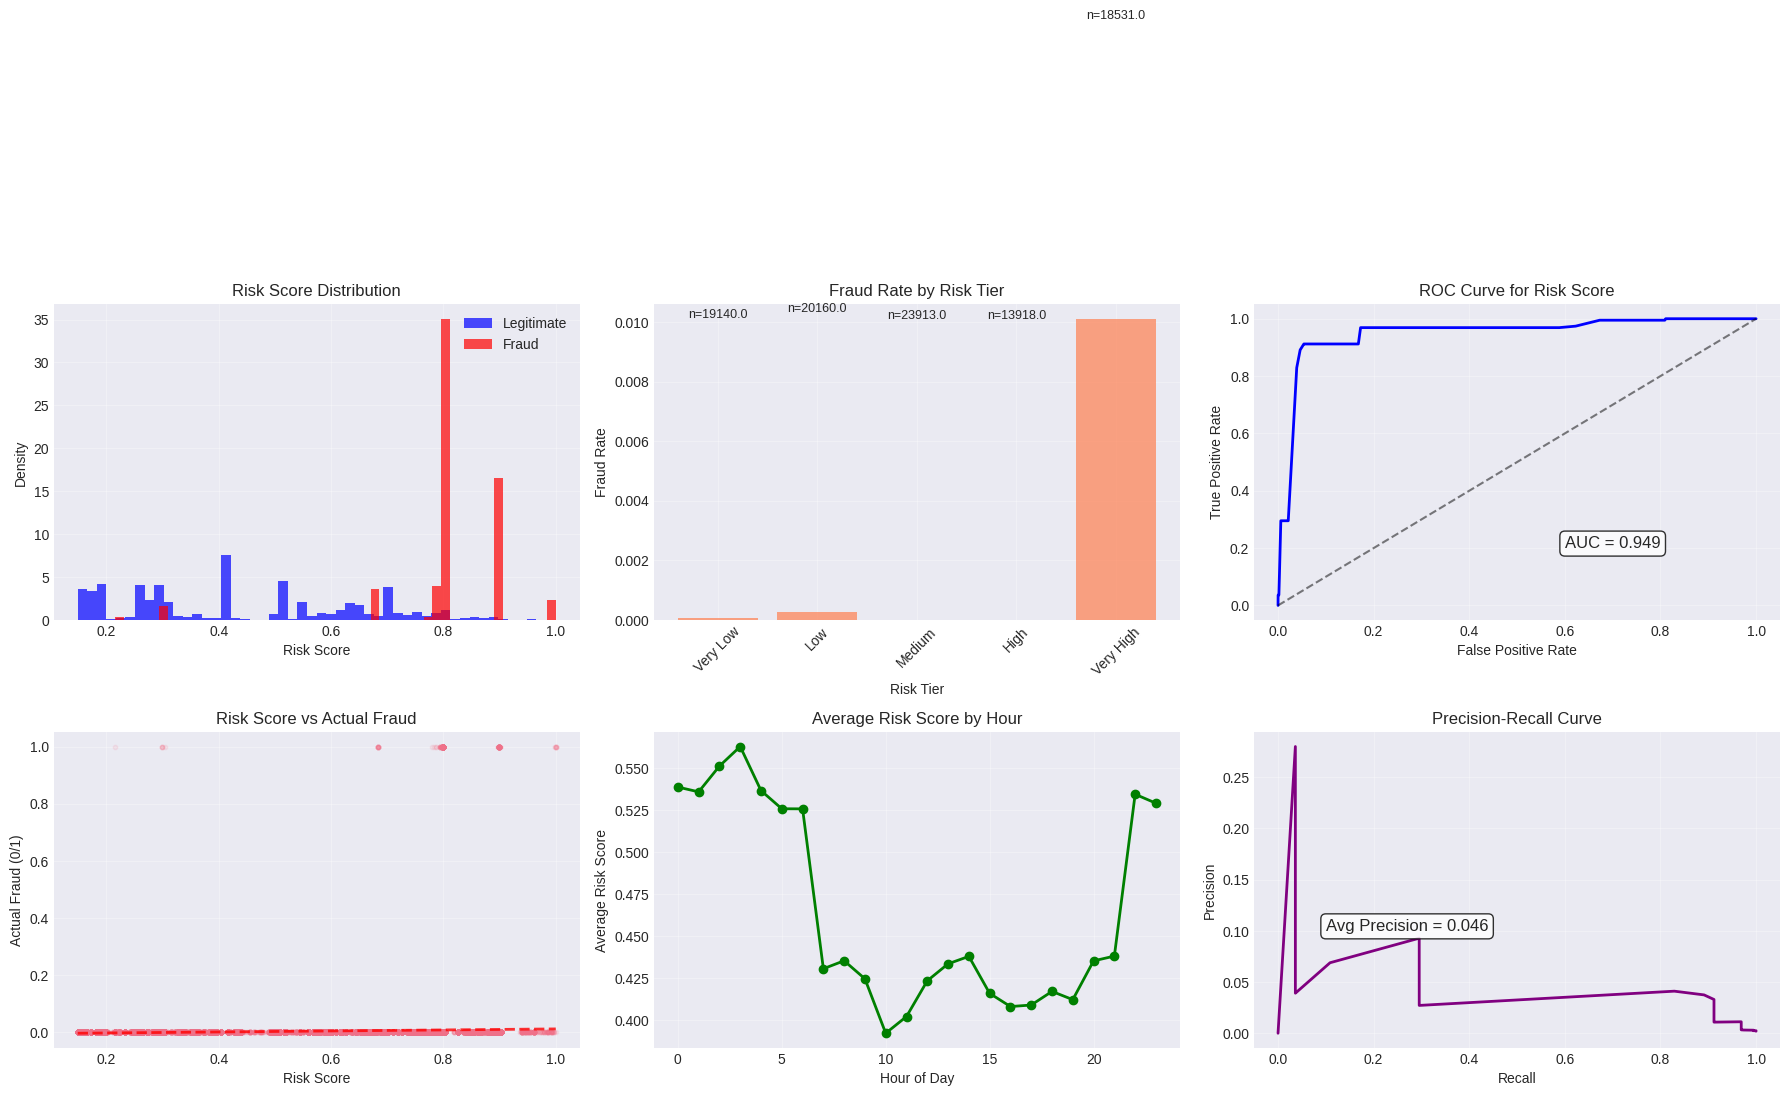


 Risk Scoring Results:
Risk Score AUC: 0.949
Average Precision: 0.046

 Risk Tier Performance:
  Very Low: 0.0% fraud rate (n=19140.0)
  Low: 0.0% fraud rate (n=20160.0)
  Medium: 0.0% fraud rate (n=23913.0)
  High: 0.0% fraud rate (n=13918.0)
  Very High: 1.0% fraud rate (n=18531.0)

 Optimal Risk Threshold: 0.778
   TPR: 0.912, FPR: 0.054

 Risk Score - Fraud Correlation: 0.082


In [ ]:
# Create advanced risk scoring model
print(" ADVANCED RISK SCORING MODEL")
print("="*50)

# Create a composite risk score
def create_risk_score(df):
    """Create a composite risk score based on multiple factors"""
    risk_score = 0
    weight_sum = 0

    # Amount-based risk (normalized)
    if 'Amount' in df.columns:
        amount_percentile = df['Amount'].rank(pct=True)
        risk_score += amount_percentile * 0.3
        weight_sum += 0.3

    # Value-based risk (normalized)
    if 'Value' in df.columns:
        value_percentile = df['Value'].rank(pct=True)
        risk_score += value_percentile * 0.3
        weight_sum += 0.3

    # Time-based risk
    if 'IsLateNight' in df.columns:
        risk_score += df['IsLateNight'] * 0.1
        weight_sum += 0.1

    # Weekend risk
    if 'IsWeekend' in df.columns:
        risk_score += df['IsWeekend'] * 0.1
        weight_sum += 0.1

    # Ratio-based risk
    if 'Amount_Value_Ratio' in df.columns:
        ratio_percentile = df['Amount_Value_Ratio'].rank(pct=True)
        risk_score += ratio_percentile * 0.2
        weight_sum += 0.2

    # Normalize by total weights
    if weight_sum > 0:
        risk_score = risk_score / weight_sum

    return risk_score

# Calculate risk scores
print("Calculating composite risk scores...")
train['RiskScore'] = create_risk_score(train)

# Create risk tiers
train['RiskTier'] = pd.qcut(train['RiskScore'], q=5,
                           labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Analysis of risk scores
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Risk score distribution
axes[0,0].hist(train[train['FraudResult']==0]['RiskScore'], bins=50, alpha=0.7,
               label='Legitimate', density=True, color='blue')
axes[0,0].hist(train[train['FraudResult']==1]['RiskScore'], bins=50, alpha=0.7,
               label='Fraud', density=True, color='red')
axes[0,0].set_xlabel('Risk Score')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Risk Score Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Risk tier analysis
tier_analysis = train.groupby('RiskTier')['FraudResult'].agg(['sum', 'count', 'mean'])
axes[0,1].bar(tier_analysis.index, tier_analysis['mean'], color='coral', alpha=0.7)
axes[0,1].set_xlabel('Risk Tier')
axes[0,1].set_ylabel('Fraud Rate')
axes[0,1].set_title('Fraud Rate by Risk Tier')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Add count labels
for i, (tier, row) in enumerate(tier_analysis.iterrows()):
    axes[0,1].text(i, row['mean'] + 0.01, f"n={row['count']}",
                   ha='center', va='bottom', fontsize=9)

# 3. ROC-like curve for risk score
from scipy import stats
risk_thresholds = np.linspace(0, 1, 100)
tpr_list, fpr_list = [], []

for threshold in risk_thresholds:
    predicted_fraud = (train['RiskScore'] >= threshold).astype(int)

    tp = len(train[(predicted_fraud == 1) & (train['FraudResult'] == 1)])
    fp = len(train[(predicted_fraud == 1) & (train['FraudResult'] == 0)])
    tn = len(train[(predicted_fraud == 0) & (train['FraudResult'] == 0)])
    fn = len(train[(predicted_fraud == 0) & (train['FraudResult'] == 1)])

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    tpr_list.append(tpr)
    fpr_list.append(fpr)

axes[0,2].plot(fpr_list, tpr_list, linewidth=2, color='blue')
axes[0,2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,2].set_xlabel('False Positive Rate')
axes[0,2].set_ylabel('True Positive Rate')
axes[0,2].set_title('ROC Curve for Risk Score')
axes[0,2].grid(True, alpha=0.3)

# Calculate AUC
from sklearn.metrics import auc
roc_auc = auc(fpr_list, tpr_list)
axes[0,2].text(0.6, 0.2, f'AUC = {roc_auc:.3f}', fontsize=12,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Risk score vs actual fraud scatter
axes[1,0].scatter(train['RiskScore'], train['FraudResult'], alpha=0.1, s=10)
axes[1,0].set_xlabel('Risk Score')
axes[1,0].set_ylabel('Actual Fraud (0/1)')
axes[1,0].set_title('Risk Score vs Actual Fraud')
axes[1,0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(train['RiskScore'], train['FraudResult'], 1)
p = np.poly1d(z)
axes[1,0].plot(train['RiskScore'].sort_values(), p(train['RiskScore'].sort_values()),
               "r--", alpha=0.8, linewidth=2)

# 5. Risk score by different segments
if 'Hour' in train.columns:
    hourly_risk = train.groupby('Hour')['RiskScore'].mean()
    axes[1,1].plot(hourly_risk.index, hourly_risk.values, marker='o', linewidth=2, color='green')
    axes[1,1].set_xlabel('Hour of Day')
    axes[1,1].set_ylabel('Average Risk Score')
    axes[1,1].set_title('Average Risk Score by Hour')
    axes[1,1].grid(True, alpha=0.3)

# 6. Precision-Recall curve
precision_list, recall_list = [], []

for threshold in risk_thresholds:
    predicted_fraud = (train['RiskScore'] >= threshold).astype(int)

    tp = len(train[(predicted_fraud == 1) & (train['FraudResult'] == 1)])
    fp = len(train[(predicted_fraud == 1) & (train['FraudResult'] == 0)])
    fn = len(train[(predicted_fraud == 0) & (train['FraudResult'] == 1)])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    precision_list.append(precision)
    recall_list.append(recall)

axes[1,2].plot(recall_list, precision_list, linewidth=2, color='purple')
axes[1,2].set_xlabel('Recall')
axes[1,2].set_ylabel('Precision')
axes[1,2].set_title('Precision-Recall Curve')
axes[1,2].grid(True, alpha=0.3)

# Calculate Average Precision
avg_precision = auc(recall_list, precision_list)
axes[1,2].text(0.1, 0.1, f'Avg Precision = {avg_precision:.3f}', fontsize=12,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print risk scoring results
print(f"\n Risk Scoring Results:")
print(f"Risk Score AUC: {roc_auc:.3f}")
print(f"Average Precision: {avg_precision:.3f}")

print(f"\n Risk Tier Performance:")
for tier, row in tier_analysis.iterrows():
    print(f"  {tier}: {row['mean']:.1%} fraud rate (n={row['count']})")

# Find optimal threshold
optimal_idx = np.argmax(np.array(tpr_list) - np.array(fpr_list))
optimal_threshold = risk_thresholds[optimal_idx]
print(f"\n Optimal Risk Threshold: {optimal_threshold:.3f}")
print(f"   TPR: {tpr_list[optimal_idx]:.3f}, FPR: {fpr_list[optimal_idx]:.3f}")

# Correlation with actual fraud
risk_fraud_corr = train['RiskScore'].corr(train['FraudResult'])
print(f"\n Risk Score - Fraud Correlation: {risk_fraud_corr:.3f}")


 Adding Linear SVM to the pipeline

🚀 Training LinearSVM...


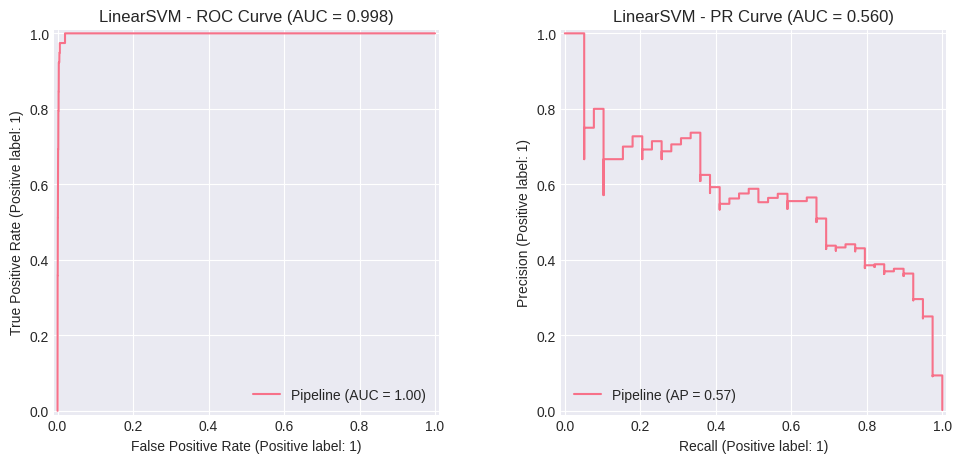


 LinearSVM Results:
              precision    recall  f1-score   support

           0      1.000     0.989     0.995     19094
           1      0.157     0.974     0.270        39

    accuracy                          0.989     19133
   macro avg      0.578     0.982     0.633     19133
weighted avg      0.998     0.989     0.993     19133

Confusion Matrix:
 [[18890   204]
 [    1    38]]

 UPDATED MODEL COMPARISON
LightGBM: ROC-AUC=0.998, PR-AUC=0.933
XGBoost: ROC-AUC=0.986, PR-AUC=0.771
LinearSVM: ROC-AUC=0.998, PR-AUC=0.560


In [ ]:
# Add SVM to the supervised fraud detection pipeline
print("\n Adding Linear SVM to the pipeline")
print("="*60)

try:
    from sklearn.svm import LinearSVC
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline

    # Scale the data before applying SVM
    scaler = StandardScaler()

    # Define the Linear SVM model
    # Use class_weight='balanced' to handle imbalance
    svm_model = make_pipeline(scaler, LinearSVC(class_weight='balanced', random_state=42, dual=False, max_iter=10000))

    # Add SVM to the existing models dictionary
    models["LinearSVM"] = svm_model

    # Train & Evaluate the new model
    name = "LinearSVM"
    model = models[name]

    print(f"\n🚀 Training {name}...")
    model.fit(X_train, y_train)

    # Predictions
    # LinearSVC does not have predict_proba, use decision_function
    y_pred = model.predict(X_test)
    y_scores = model.decision_function(X_test) # Use decision_function for metrics

    # Metrics
    roc_auc = roc_auc_score(y_test, y_scores)
    precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label=model.classes_[1])
    pr_auc = auc(recall, precision)

    results[name] = {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "report": classification_report(y_test, y_pred, zero_division=0, digits=3),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
    axes[0].set_title(f"{name} - ROC Curve (AUC = {roc_auc:.3f})")

    # Precision-Recall Curve
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[1])
    axes[1].set_title(f"{name} - PR Curve (AUC = {pr_auc:.3f})")

    plt.show()

    # Print report
    print(f"\n {name} Results:")
    print(results[name]["report"])
    print("Confusion Matrix:\n", results[name]["conf_matrix"])

    # Update model comparison printout
    print("\n UPDATED MODEL COMPARISON")
    print("="*60)
    for name, res in results.items():
        print(f"{name}: ROC-AUC={res['roc_auc']:.3f}, PR-AUC={res['pr_auc']:.3f}")


except ImportError:
    print("Scikit-learn is required for SVM. Install with:")
    print("!pip install scikit-learn")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
# Prepare data for model training and export key results
print(" DATA EXPORT AND MODEL PREPARATION")
print("="*50)

# Create a clean dataset for modeling
modeling_features = []

# Add original numerical features
base_features = ['Amount', 'Value']
for feature in base_features:
    if feature in train.columns:
        modeling_features.append(feature)

# Add engineered features
engineered_features = ['LogAmount', 'LogValue', 'Amount_Value_Ratio',
                      'Amount_Value_Interaction', 'IsWeekend', 'IsBusinessHour',
                      'IsLateNight']
for feature in engineered_features:
    if feature in train.columns:
        modeling_features.append(feature)

# Add categorical features as numeric
categorical_features = ['CountryCode', 'ProviderId', 'ProductId', 'ChannelId', 'PricingStrategy']
for feature in categorical_features:
    if feature in train.columns and train[feature].dtype in ['int64', 'float64']:
        modeling_features.append(feature)

# Add risk score
if 'RiskScore' in train.columns:
    modeling_features.append('RiskScore')

print(f" Features selected for modeling: {len(modeling_features)}")
for i, feature in enumerate(modeling_features, 1):
    print(f"  {i:2d}. {feature}")

# Create modeling dataset
modeling_data = train[modeling_features + ['FraudResult']].copy()

# Handle missing values
print(f"\n Data cleaning:")
missing_before = modeling_data.isnull().sum().sum()
modeling_data = modeling_data.fillna(0)  # Simple imputation
missing_after = modeling_data.isnull().sum().sum()
print(f"  Missing values: {missing_before} → {missing_after}")

# Remove infinite values
inf_before = np.isinf(modeling_data.select_dtypes(include=[np.number])).sum().sum()
modeling_data = modeling_data.replace([np.inf, -np.inf], 0)
inf_before_after = np.isinf(modeling_data.select_dtypes(include=[np.number])).sum().sum()
print(f"  Infinite values: {inf_before} → {inf_before_after}")

# Feature statistics for modeling
print(f"\n Modeling dataset statistics:")
print(f"  Shape: {modeling_data.shape}")
print(f"  Memory usage: {modeling_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  Fraud rate: {modeling_data['FraudResult'].mean():.1%}")

# Export correlation matrix
feature_correlations = modeling_data.corr()['FraudResult'].drop('FraudResult').sort_values(key=abs, ascending=False)
print(f"\n Top 5 feature correlations with fraud:")
for feature, corr in feature_correlations.head().items():
    print(f"  {feature}: {corr:.3f}")

# Create feature importance ranking
feature_importance_df = pd.DataFrame({
    'Feature': feature_correlations.index,
    'Correlation': feature_correlations.values,
    'AbsCorrelation': feature_correlations.abs().values
}).sort_values('AbsCorrelation', ascending=False)

print(f"\n Feature importance ranking created")

# Prepare data splits information
print(f"\n Data split recommendations:")
print(f"  Total samples: {len(modeling_data):,}")
print(f"  Suggested train size: {int(len(modeling_data) * 0.7):,} (70%)")
print(f"  Suggested validation size: {int(len(modeling_data) * 0.15):,} (15%)")
print(f"  Suggested test size: {int(len(modeling_data) * 0.15):,} (15%)")

# Save key datasets (in practice, you'd save to files)
print(f"\n Key datasets prepared:")
print("   modeling_data - Clean dataset for ML models")
print("   feature_importance_df - Feature ranking by correlation")
print("   analysis_summary - Key metrics dictionary")

# Sample code for saving (uncomment to use)
# modeling_data.to_csv('fraud_modeling_data.csv', index=False)
# feature_importance_df.to_csv('feature_importance.csv', index=False)
# pd.DataFrame([analysis_summary]).to_csv('analysis_summary.csv', index=False)

print(f"\n✅ Data preparation complete!")
print(f" Ready for machine learning model training")

# Display final modeling dataset info
print(f"\n Final modeling dataset preview:")
display(modeling_data.head())
print(f"\nDataset info:")
print(modeling_data.info())

 DATA EXPORT AND MODEL PREPARATION
 Features selected for modeling: 12
   1. Amount
   2. Value
   3. LogAmount
   4. LogValue
   5. Amount_Value_Ratio
   6. Amount_Value_Interaction
   7. IsWeekend
   8. IsBusinessHour
   9. IsLateNight
  10. CountryCode
  11. PricingStrategy
  12. RiskScore

 Data cleaning:
  Missing values: 38189 → 0
  Infinite values: 0 → 0

 Modeling dataset statistics:
  Shape: (95662, 13)
  Memory usage: 9.49 MB
  Fraud rate: 0.2%

 Top 5 feature correlations with fraud:
  Value: 0.567
  Amount: 0.557
  Amount_Value_Interaction: 0.342
  LogValue: 0.139
  LogAmount: 0.096

 Feature importance ranking created

 Data split recommendations:
  Total samples: 95,662
  Suggested train size: 66,963 (70%)
  Suggested validation size: 14,349 (15%)
  Suggested test size: 14,349 (15%)

 Key datasets prepared:
   modeling_data - Clean dataset for ML models
   feature_importance_df - Feature ranking by correlation
   analysis_summary - Key metrics dictionary

✅ Data preparati

,Amount,Value,LogAmount,LogValue,Amount_Value_Ratio,Amount_Value_Interaction,IsWeekend,IsBusinessHour,IsLateNight,CountryCode,PricingStrategy,RiskScore,FraudResult
0,1000.0,1000,6.908755,6.908755,1.000000,1000000.0,0,0,1,256,2,0.516568,0
1,-20.0,20,0.000000,3.044522,-1.000000,-400.0,0,0,1,256,2,0.293172,0
2,500.0,500,6.216606,6.216606,1.000000,250000.0,0,0,1,256,2,0.404305,0
3,20000.0,21800,9.903538,9.989711,0.917431,436000000.0,0,0,1,256,2,0.753327,0
4,-644.0,644,0.000000,6.469250,-1.000000,-414736.0,0,0,1,256,2,0.264816,0



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Amount                    95662 non-null  float64
 1   Value                     95662 non-null  int64  
 2   LogAmount                 95662 non-null  float64
 3   LogValue                  95662 non-null  float64
 4   Amount_Value_Ratio        95662 non-null  float64
 5   Amount_Value_Interaction  95662 non-null  float64
 6   IsWeekend                 95662 non-null  int64  
 7   IsBusinessHour            95662 non-null  int64  
 8   IsLateNight               95662 non-null  int64  
 9   CountryCode               95662 non-null  int64  
 10  PricingStrategy           95662 non-null  int64  
 11  RiskScore                 95662 non-null  float64
 12  FraudResult               95662 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 9.5 MB
N